In [169]:
import matplotlib.pyplot as plt
import autograd as ag
import autograd.numpy as np
import scipy.linalg as la
import scipy.signal as sp
import scipy.stats as st
import scipy.integrate as itg
%matplotlib inline

In [170]:
# let start our project
#We want to keep track of car to find its moving characters.
#fortunately we have some anntenas sending the signals and receive those feedback messages.
#Assume a user is moving xi+1=Phi*xi Yi=Phi*xi
#Let us start place some antennas in the area.

In this Project, we will use the extended Kalman filter to track the movement of a simple 
vehicle model given in discrete-time by:
\begin{equation*}
\begin{bmatrix}
p_x[k+1] \\
p_y[k+1] \\
\theta[k+1]
\end{bmatrix}
=
\begin{bmatrix}
p_x[k] \\
p_y[k] \\
\theta[k]
\end{bmatrix} + dt 
\begin{bmatrix}
u_v[k] \cos(\theta[k]) \\ 
u_v[k] \sin(\theta[k]) \\
u_\omega[k]
\end{bmatrix}
+w[k].
\end{equation*}




Here $dt$ is the time-step and $w[k]$ is the process noise. We will assume that $dt=0.1$ and the process noise is independent Gaussian noise distributed as $w[k] \sim \mathcal{N}(0,0.0001I)$.

We stack the state and inputs as:
\begin{equation*}
x[k] = \begin{bmatrix}
p_x[k] \\
p_y[k] \\
\theta[k]
\end{bmatrix}
\quad 
u[k] = \begin{bmatrix}
u_v[k] \\
u_\omega[k]
\end{bmatrix}
\end{equation*}

The initial condition, control input, $u[0],\ldots,u[100]$, and noise terms $w[0],\ldots,w[100]$ are given below. 


In [294]:
#Assume initial is 
x0=np.array([-1.42272315,1.66878427,-7.02389097])
#Assume a driver does 5 moves 
n_u=5
#u=(np.random.rand(n_u,2)-np.array([0,0.5]))* np.array([2,1])
u=np.array([[1.49609465,0.24219884],
 [0.92401463,0.45875257],
 [0.10876148,0.43543185],
 [1.97321445,0.46318528],
 [0.49352292,0.38270178]])
#set every move is equal to 20 unit time
num=20
U=np.repeat(u, 20, axis=0)
#add noise
total=n_u*num
Wp=0.0001 * np.random.randn(total, 3)
#print(U)


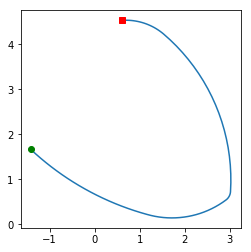

In [295]:
list=[(x0)]
temp=(x0)
for k in range(total):
    temp=temp+([0.1*U[k][0]*np.cos(temp[2]),0.1*U[k][0]*np.sin(temp[2]),0.1*U[k][1]])+(Wp[k])
    list.append(temp)
X=np.array(list)
plt.plot(X[:,0],X[:,1])
plt.plot(X[0,0],X[0,1],'go')
plt.plot(X[-1,0],X[-1,1],'rs')
plt.gca().set_aspect('equal')



In [296]:
dfdx = ag.jacobian(step,0)
dfdw = ag.jacobian(step,2)

def dot(*mats):
    if len(mats) == 1:
        return mats[0]
    else:
        return np.dot(mats[0],dot(*mats[1:]))

def carTimeUpdate(x,P,u):
    w =np.zeros(3)

    x_next = step(x,u,w)
    
    F = dfdx(x,u,w)
    L = dfdw(x,u,w)

    Q = 0.0001 * np.eye(3)
    P_next = dot(F,P,F.T) + dot(L,Q,L.T)

    return x_next,P_next


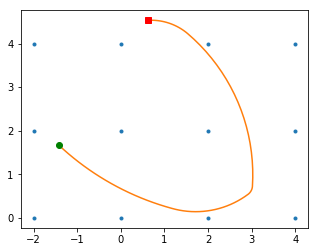

In [297]:
Sen_num=len(range(-2, 5, 2))*len((0, 5, 2))
SensorLocs =np.zeros(shape=(Sen_num,2))
i=0
for xx in range(-2, 5, 2):
    for yy in range(0, 5, 2) :
        SensorLocs[i,0]=xx
        SensorLocs[i,1]=yy
        i=i+1
        
#print(SensorLocs)
#print(a)
# Each row of SensorStr is the x-y coordinate of a sensor
plt.plot(SensorLocs[:,0],SensorLocs[:,1],'.')
plt.plot(X[:,0],X[:,1])
plt.plot(X[0,0],X[0,1],'go')
plt.plot(X[-1,0],X[-1,1],'rs')
plt.gca().set_aspect('equal')



In [331]:
la.norm(X[0,:2]-SensorLocs,axis=1)


array([1.76581129, 0.66554671, 2.40162764, 2.19293915, 1.46076864,
       2.73106352, 3.8078701 , 3.43871162, 4.14120762, 5.6736908 ,
       5.43282893, 5.9025836 ])

In [332]:
#Calculate Y

Y=np.zeros((len(X),Sen_num))
for i in range(len(X)):
    Y[i,:]=la.norm(X[i,:2]-SensorLocs,axis=1)


    


In [333]:
# Define your function here
nSensors = len(SensorLocs)
print(nSensors)
noiseStd = 0.2
def measure(x,v):
    d = np.linalg.norm(SensorLocs-np.outer(np.ones(nSensors),x[:2]),axis=1)
    y = d + noiseStd * (1+d)*v
    return y

dhdx = ag.jacobian(measure,0)
dhdv = ag.jacobian(measure,1)




12


In [334]:
dt=0.1
mu = np.zeros(3)
P = 10 * np.eye(3)

Mu_list = []
P_list = []

for k,y in enumerate(Y):
    Mu_list.append(mu)
    P_list.append(P)
    v = np.zeros_like(y)
    H = dhdx(x,v)
    G = dhdv(x,v)
    Psi = dot(H,P,H.T) + dot(G,G.T)
    K = np.linalg.solve(Psi,np.dot(H,P)).T
    h = measure(x,v)
    x_next = x + np.dot(K,y-h)
    P_next = P - dot(K,Psi,K.T)
    mu=x_next
    P=P_next
    #print(mu)
    #Mu_list.append(mu)
    #P_list.append(P)

    if k < len(U):
        mu,P = carTimeUpdate(mu,P,U[k])

Mu = np.array(Mu_list)
P_arr = np.array(P_list)




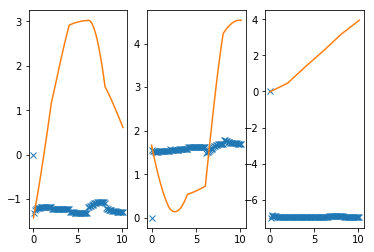

In [335]:
# Make your plots here.

time=np.linspace(0,(total+1)*dt,num=total+1)
plt.subplot(1,3,1)
plt.plot(time,Mu[:,0],'x')
plt.plot(time,X[:,0],'-')
plt.subplot(1,3,2)
plt.plot(time,Mu[:,1],'x')
plt.plot(time,X[:,1],'-')
plt.subplot(1,3,3)
plt.plot(time,Mu[:,2],'x')
plt.plot(time,X[:,2]+7,'-')
#matplotlib.pyplot.ylim(-3.14,3.14)

In [265]:
print(Mu)

[[-1.42272315  1.66878427 -7.02389097]
 [-1.36112731  1.62592075 -6.88484577]
 [-1.34125458  1.61335452 -6.92758385]
 [-1.3277598   1.61167172 -6.92643736]
 [-1.31933329  1.61160395 -6.93338588]
 [-1.31296727  1.61281657 -6.93872629]
 [-1.30803877  1.61439307 -6.94373057]
 [-1.30419126  1.6159649  -6.94854508]
 [-1.30113514  1.6174173  -6.95307748]
 [-1.29874485  1.61856994 -6.95744897]
 [-1.29686828  1.61954997 -6.96151013]
 [-1.29538551  1.62043393 -6.96521744]
 [-1.29417183  1.62137204 -6.96849786]
 [-1.29321775  1.62243011 -6.97140776]
 [-1.2924476   1.62369292 -6.97394078]
 [-1.29181617  1.62514764 -6.97614825]
 [-1.29129499  1.62664769 -6.97812915]
 [-1.29084859  1.62807588 -6.97994433]
 [-1.29048196  1.62931358 -6.98165916]
 [-1.29017748  1.63031686 -6.98329129]
 [-1.28990366  1.63109093 -6.98483418]
 [-1.29359359  1.62891672 -6.98816632]
 [-1.29626152  1.62764563 -6.99057748]
 [-1.29817808  1.62700309 -6.9923387 ]
 [-1.29952435  1.62679705 -6.99363038]
 [-1.30043213  1.6269003 

In [278]:
# Calculate the estimates here
# Call them Mu and P_arr
#dt=0.1
#mu = np.zeros(3)
#P = 10 * np.eye(3)

#Mu_list = []
#P_list = []

#for k,y in enumerate(Y):
#    mu,P = carMeasUpdate(mu,P,y)
#    #print(mu)
#    Mu_list.append(mu)
#    P_list.append(P)

#    if k < len(U):
#        mu,P = carTimeUpdate(mu,P,U[k])

#Mu = np.array(Mu_list)
#P_arr = np.array(P_list)
#Mu.shape


def carMeasUpdate(x,P,y):
    v = np.zeros_like(y)
    H = dhdx(x,v)
    G = dhdv(x,v)
    Psi = dot(H,P,H.T) + dot(G,G.T)
    
    K = np.linalg.solve(Psi,np.dot(H,P)).T
    
    h = measure(x,v)
    print(H)
    x_next = x + np.dot(K,y-h)
    P_next = P - dot(K,Psi,K.T)

    return x_next,P_next